In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 


import json



In [2]:
import utils_generic as generic
import singletask_dep as st
import model_confs as confs


import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

In [4]:
model_conf = confs.distilbert_conf
encoding_type = 'absolute'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_distilbert_ABOUT_abs'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.48086734693877553
MALE 0.953125
FEMALE 0.0275 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.5
MALE 0.927007299270073
FEMALE 0.03937007874015748 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.5123859191655802
MALE 0.9621212121212122
FEMALE 0.03234501347708895 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6812456833776281 	 Validation loss: 0.6820811376733295 	 
  1%|          | 574/57400 [02:00<3:12:44,  4.91it/s]
Epoch 2 	 Training loss: 0.6763539764939285 	 Validation loss: 0.6752916564375667 	 
  2%|▏         | 1148/57400 [04:03<3:16:46,  4.76it/s]
Epoch 3 	 Training loss: 0.6623809770632288 	 Validation loss: 0.6454295414989277 	 
  3%|▎         | 1722/57400 [06:08<3:09:51,  4.89it/s]
Epoch 4 	 Training loss: 0.5981277451178754 	 Validation loss: 0.5317685028253976 	 
  4%|▍         | 2296/57400 [08:12<3:08:35,  4.87it/s]
Epoch 5 	 Training loss: 0.4905194067477349 	 Validation loss: 0.44647633271702264 	 
  5%|▌         | 2870/57400 [10:16<2:33:59,  5.90it/s]
Epoch 6 	 Training loss: 0.43556774675015375 	 Validation loss: 0.40645225522881845 	 
  6%|▌         | 3444/57400 [12:21<3:14:47,  4.62it/s]
Epoch 7 	 Training loss: 0.4065226735449834 	 Validation loss: 0.3804326239278761 	 
  7%|▋         | 4018/57400 [14:23<3:02:41,  4.87it/s]
Epoch 8 	 Training

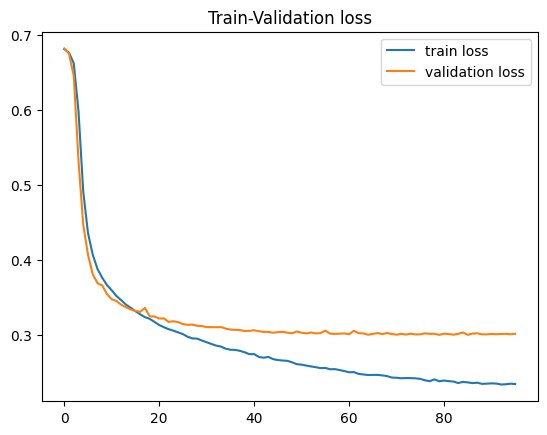

In [17]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.8392857142857143
MALE 0.8385416666666666
FEMALE 0.84 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.6565656565656566
MALE 0.6788321167883211
FEMALE 0.6325459317585301 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.6766623207301173
MALE 0.6641414141414141
FEMALE 0.6900269541778976 



# TO

In [19]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_distilbert_TO_abs'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6944143202039007 	 Validation loss: 0.6931035316596597 	 
  1%|          | 574/57400 [01:57<3:03:35,  5.16it/s]
Epoch 2 	 Training loss: 0.6941189733739513 	 Validation loss: 0.6932535888785023 	 
  2%|▏         | 1148/57400 [03:54<3:08:48,  4.97it/s]
Epoch 3 	 Training loss: 0.6937905585308939 	 Validation loss: 0.6926175780215506 	 
  3%|▎         | 1722/57400 [05:51<2:56:54,  5.25it/s]
Epoch 4 	 Training loss: 0.6938664891370913 	 Validation loss: 0.6929795014656196 	 
  4%|▍         | 2296/57400 [07:47<2:58:24,  5.15it/s]
Epoch 5 	 Training loss: 0.6939261033352244 	 Validation loss: 0.6927525047528542 	 
  5%|▌         | 2870/57400 [09:44<2:52:29,  5.27it/s]
Epoch 6 	 Training loss: 0.6938868460962582 	 Validation loss: 0.6941171783511921 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [11:41<2:59:26,  5.01it/s]
Epoch 7 	 Training loss: 0.6933213458867024 	 Validation loss: 0.692838555675442 	 
  7%|▋         | 4018/57400 [13:37<2:22:37,  6.2

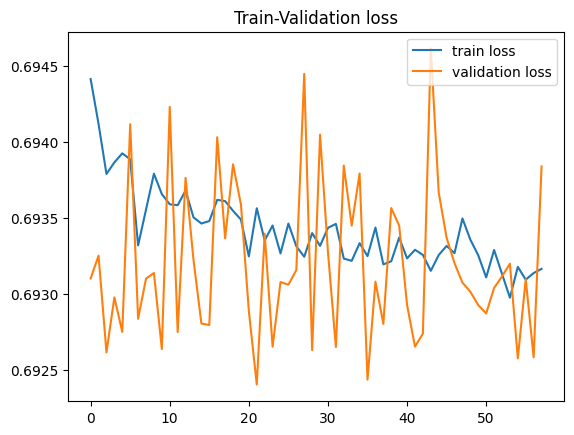

In [20]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [21]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.49744897959183676
MALE 0.22135416666666666
FEMALE 0.7625 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.48737373737373735
MALE 0.22384428223844283
FEMALE 0.7716535433070866 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.5032594524119948
MALE 0.25
FEMALE 0.7735849056603774 



# AS

In [22]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_distilbert_AS_abs'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6951502343503441 	 Validation loss: 0.6937142226655605 	 
  1%|          | 574/57400 [01:57<3:03:59,  5.15it/s]
Epoch 2 	 Training loss: 0.694285354963163 	 Validation loss: 0.6913476263062429 	 
  2%|▏         | 1148/57400 [03:54<3:02:14,  5.14it/s]
Epoch 3 	 Training loss: 0.6942405358008806 	 Validation loss: 0.6935150532399194 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [05:51<2:34:27,  6.01it/s]
Epoch 4 	 Training loss: 0.6942841725274661 	 Validation loss: 0.6924290263046653 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [07:48<3:04:47,  4.97it/s]
Epoch 5 	 Training loss: 0.6941255998736059 	 Validation loss: 0.6922982021913691 	 
  5%|▌         | 2870/57400 [09:45<2:59:39,  5.06it/s]
Epoch 6 	 Training loss: 0.6933756110352506 	 Validation loss: 0.6930295168343237 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [11:42<3:02:49,  4.92it/s]
Epoch 7 	 Training loss: 0.6936439230051605 	 Validation loss: 0.6927140809

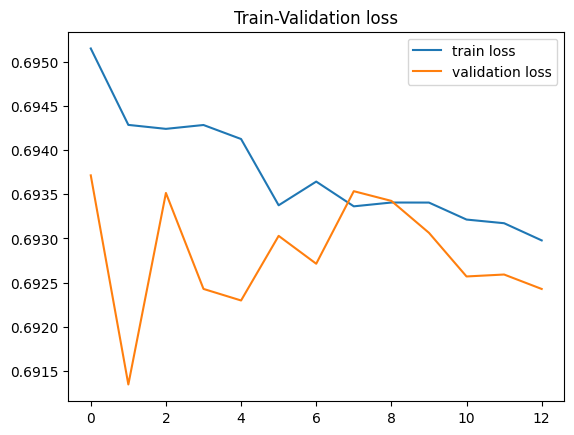

In [23]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [24]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.48596938775510207
MALE 0.052083333333333336
FEMALE 0.9025 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.4659090909090909
MALE 0.06569343065693431
FEMALE 0.8976377952755905 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.4876140808344198
MALE 0.08333333333333333
FEMALE 0.9191374663072777 

